In [19]:
import sys
import numpy as np
import math
import pandas as pd
import random

from scipy import stats

%matplotlib inline

import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rc('font',family='serif')
matplotlib.rc('font',weight='bold')
matplotlib.rc('font',size=16)
matplotlib.rcParams['axes.labelweight'] = 'bold'

from recommender_functions import *
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve,roc_auc_score
from sklearn import model_selection

import random

In [20]:
week = 'Week4'
day  = 'Mon'

In [21]:
# Get the ratings by user ID: starts at user index 1 
r = pd.read_csv('goodbooks-10k/ratings.csv')
df_ratings = pd.DataFrame(r)

# Add counts to the df
cut_u, cut_b = 175, 1 #175, 1
df_ratings['user_counts'] = df_ratings.groupby(['user_id'])['book_id'].transform('count')
df_ratings['book_counts'] = df_ratings.groupby(['book_id'])['user_id'].transform('count')
df_ratings_cut = df_ratings.query('user_counts > %d '%(cut_u))

# Add an index for the user for matrix making later
df_ratings_cut['user_idx'] = pd.Categorical(df_ratings_cut['user_id']).codes 
df_ratings_cut['book_idx'] = pd.Categorical(df_ratings_cut['book_id']).codes 

df_ratings_cut.to_csv('ratings_cut.csv', sep=',')

# ...but also do a groupby, so can plot easily
df_ratings_count_u = df_ratings.groupby(['user_id']).size().reset_index(name='Counts')

r = pd.read_csv('goodbooks-10k/books_with_genres.csv')
df_books = pd.DataFrame(r)
df_ratings_cut.head()

r = pd.read_csv('goodbooks-10k/ahack_tags_3.csv')
df_tags = pd.DataFrame(r)
df_tags['tag_index'] = pd.Categorical(df_tags['tag_id']).codes 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [22]:
# Set number of books and users variables for later use
N_BOOKS = len(df_ratings_cut.book_id.unique()) 
N_USERS = len(df_ratings_cut.user_id.unique())

print(N_BOOKS,N_USERS)

7337 537


## Build a Rank Matrix

In [23]:
# First, define a matrix size num_books x num_users
ratings_genre_mat = np.zeros((N_USERS,N_BOOKS))
ratings_mat = np.zeros((N_USERS,N_BOOKS))
binary_mat = np.zeros((N_USERS,N_BOOKS))

Y, R = ratings_mat, binary_mat

genre_list_dict = []

# Now fill the rank matrix and validation matrix
for i in range(df_ratings_cut.shape[0]):
    user_i = df_ratings_cut.user_idx.values[i] # This goes from 0 -> 536
    book_i = df_ratings_cut.book_idx.values[i] # This goes from 0 -> 7336
    rating_i = df_ratings_cut.rating.values[i] # This goes from 1 -> 5

    # Fill ratings + binary matrix
    ratings_mat[user_i][book_i] = rating_i
    binary_mat[user_i][book_i] = 1
    
    # Now fill the genre tag matrix
    # First link ratings matrix entry to its book in df_books
    actual_book_i = df_ratings_cut.book_id.values[i]               # book_id goes from 1 -> 10000
    book_q = df_books.loc[df_books['book_id'] == actual_book_i]
    genre, tag_id = book_q.genre.values[0], book_q.tag_id.values[0] 
    
    ratings_genre_mat[user_i][book_i] = int(tag_id)    

In [24]:
user_ave_v = ratings_mat.sum(1)/(ratings_mat!=0).sum(1).astype(float)
book_ave_v = ratings_mat.T.sum(1)/(ratings_mat.T!=0).sum(1).astype(float)

ave_mat = np.zeros((N_USERS,N_BOOKS))
user_ave_mat = np.zeros((N_USERS,N_BOOKS))

for i in range(N_USERS):
    rowi = [ (user_ave_v[i]+book_ave_v[j])/2 for j in range(N_BOOKS) ]
    ave_mat[i] = rowi
    
    row_ave = [user_ave_v[i] for j in range(N_BOOKS)]
    user_ave_mat[i] = row_ave

In [170]:
orig_ratings_mat = ratings_mat.copy()
temp = (ratings_mat == 0)
ratings_mat[temp] = ave_mat[temp]

In [26]:
# Now store the top 3 genre preferences per user 
top_3_genres_per_user = np.zeros((N_USERS,4))
top_3_genres_names_per_user = []
top_genre_names_per_user = []

for rowi in range(ratings_genre_mat.shape[0]):
    
    i = ratings_genre_mat[rowi]
    
    unique, counts = np.unique(i,return_counts=True)

    pred_idxs_sorted = np.argsort(counts)
    pred_idxs_sorted = pred_idxs_sorted[::-1]

    # Start at 1, not 0, to avoid the 0's which are most of the space
    top_3_genres_per_user[rowi][0] = unique[pred_idxs_sorted[1]] #counts[pred_idx_sorted[1]]
    top_3_genres_per_user[rowi][1] = unique[pred_idxs_sorted[2]] #counts[pred_idx_sorted[1]]
    top_3_genres_per_user[rowi][2] = unique[pred_idxs_sorted[3]] #counts[pred_idx_sorted[1]]
    top_3_genres_per_user[rowi][3] = unique[pred_idxs_sorted[4]] #counts[pred_idx_sorted[1]]
    
    first_pick = df_tags.query('tag_id == %d'%int(top_3_genres_per_user[rowi][0]))
    second_pick = df_tags.query('tag_id == %d'%int(top_3_genres_per_user[rowi][1]))
    third_pick = df_tags.query('tag_id == %d'%int(top_3_genres_per_user[rowi][2]))

    top_genre_names_per_user.append(first_pick['tag_id'].values[0])
    
    user_pref_v = [first_pick['tag_name'].values[0], second_pick['tag_name'].values[0], third_pick['tag_name'].values[0]]

    top_3_genres_names_per_user.append(user_pref_v)

In [27]:
# Ok cool, so now per user, build a matrix to blind user's top genres
# This matrix is the same size as the ratings matrix, but only has entries for 
# preferences below the user's favorite
binary_genre_mat = binary_mat.copy()

for i in range(ratings_genre_mat.shape[0]):
    rowi = ratings_genre_mat[i]
    binary_genre_mat[i] = [ 1 if ratings_genre_mat[i][j] != 0 and ratings_genre_mat[i][j] != top_genre_names_per_user[i]\
            else 0 for j in range(ratings_genre_mat.shape[1])]

In [539]:
# LEAVE K OUT TRAIN TEST
# Split between train and test, user similarity
train_set, test_set = train_test_split(ratings_mat,split=1400)
user_similarity = fast_similarity(train_set,kind='user')

print('Test :' ,float(len(np.nonzero(test_set)[0]))/(len(np.nonzero(train_set)[0])+len(np.nonzero(test_set)[0]))*100)
print('Train:' ,float(len(np.nonzero(train_set)[0]))/(len(np.nonzero(train_set)[0])+len(np.nonzero(test_set)[0]))*100)

print(len(np.nonzero(test_set)[0]),len(np.nonzero(train_set)[0]))

Test : 19.08136840670574
Train: 80.91863159329426
751800 3188169


In [541]:
#print(test_set,N_USERS*N_BOOKS)

In [373]:
# Get user predictions for only top k = 30 (mse minimum) most similar users 
user_prediction_topk = predict_topk(train_set, user_similarity, kind='user', k=30)
print( 'Top-k User-based CF MSE: ' + str(get_mse(user_prediction_topk, test_set)))

537
Top-k User-based CF MSE: 0.9877111624571442


In [389]:
# Let's also find the item similarity
#item_similarity = fast_similarity(train_set,kind='item')
#item_prediction_topk = predict_topk(train_set,item_similarity,kind='item',k=15)

#item_y_pred_topk = item_prediction_topk[nonzero_test]
#item_y_pred_scaled_topk = (item_y_pred_topk - 1.) / 4

## And now we validate

In [390]:
# LEAVE K OUT
# Blind data from user's top genre 
blind_test_set = test_set.copy() * binary_genre_mat
nonzero_test = blind_test_set > 0

blind_y_true = blind_test_set[nonzero_test]
blind_y_pred_topk = user_prediction_topk[nonzero_test]
user_ave_thresholds = user_ave_mat[nonzero_test]

blind_y_pred_scaled_topk = (blind_y_pred_topk - 1.) / 4

# Binarize true values and predictions using user's average rating as a threshold
blind_y_true_binarized = binarize(blind_y_true.copy(), user_ave_thresholds)
blind_y_pred_binarized_topk = binarize(blind_y_pred_topk.copy(), user_ave_thresholds) 

auc_score = roc_auc_score(blind_y_true_binarized, blind_y_pred_scaled_topk)
fpr_b, tpr_b, thresholds = roc_curve(blind_y_true_binarized, blind_y_pred_scaled_topk)

In [558]:
# Only real ratings in the test set
#print(blind_y_true[100:900])
print(test_set)
print(blind_y_pred_topk)
#print(blind_test_set)
#print(binary_genre_mat)
#print(binary_genre_mat)
#print(blind_y_true[10:50])
#print(blind_y_pred_topk[10:50])

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         3.23011364]
 [0.         0.         3.88786765 ... 0.         0.         0.        ]
 ...
 [0.         0.         3.2887985  ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         4.04411765 ... 0.         0.         0.        ]]
[3.27196383 2.87265214 2.49009051 ... 3.29960395 2.92161882 2.55274312]


In [543]:
#print(blind_y_true_binarized)
#print(blind_y_pred_binarized_topk)

In [421]:
user_ids = np.tile(np.array([np.arange(blind_test_set.shape[0])]).T, \
                   (1, blind_test_set.shape[1]))[nonzero_test]

In [502]:
def precision_at_k(true, pred, pred_binarized, user_ids, k, tol=[]):
    unique_users = np.unique(user_ids)
    precisions = np.zeros(unique_users.size)
    
    for i in range(unique_users.size):
        user_ind = user_ids == unique_users[i]
        user_true = true[user_ind]
        user_pred = pred[user_ind]
        user_pred_binarized = pred_binarized[user_ind]
        ranked_ind = np.argsort(-user_pred)[:k]
        precisions[i] = precision_score(user_true[ranked_ind], user_pred_binarized[ranked_ind])
    return np.mean(precisions[precisions > 0]) #precisions

In [504]:
t = user_ave_thresholds
print( '\n\nprecision @4 : ', precision_at_k(blind_y_true_binarized, blind_y_pred_topk, blind_y_pred_binarized_topk, user_ids, 4, tol=t))
print( '\n\nprecision @8 : ', precision_at_k(blind_y_true_binarized, blind_y_pred_topk, blind_y_pred_binarized_topk, user_ids, 8, tol=t))
print( '\n\nprecision @16 : ', precision_at_k(blind_y_true_binarized, blind_y_pred_topk, blind_y_pred_binarized_topk, user_ids, 16, tol=t))

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)




precision @4 :  0.8128720238095237


precision @8 :  0.778952589807853


precision @16 :  0.7670790878214458


In [505]:
def recall_at_k(true, pred, user_ids, k, tol=.5):
    unique_users = np.unique(user_ids)
    pred_binarized = binarize(pred.copy(), tol)
    recalls = np.zeros(unique_users.size)
    # 537 users
    for i in range(unique_users.size):
        user_ind = user_ids == unique_users[i]
        user_true = true[user_ind] 
        user_pred = pred[user_ind]
        user_pred_binarized = pred_binarized[user_ind]
        ranked_ind = np.argsort(-user_pred)[:k]
        #print('Ranked stuff' ,ranked_ind,user_true[ranked_ind],user_pred_binarized[ranked_ind])
        #print(user_true)
        recalls[i] = recall_score(user_true[ranked_ind], user_pred_binarized[ranked_ind])
    return np.mean(recalls[recalls > 0])


In [472]:
print( '\n\nrecall @4 : %0.3f' % recall_at_k(blind_y_true_binarized, blind_y_pred_scaled_topk, user_ids,4, tol=t))
#print( 'recall @8 : %0.3f' % recall_at_k(blind_y_true_binarized, blind_y_pred_scaled_topk, user_ids, 8, tol=t))
#print( 'recall @16 : %0.3f' % recall_at_k(blind_y_true_binarized,blind_y_pred_scaled_topk, user_ids, 16, tol=t))
#print( 'recall @32 : %0.3f' % recall_at_k(blind_y_true_binarized,blind_y_pred_scaled_topk, user_ids, 32, tol=t))

Ranked stuff [ 8  6 11  4] [0. 0. 0. 0.] [1. 1. 1. 1.]
Ranked stuff [ 2  1  4 17] [1. 1. 0. 0.] [1. 1. 1. 1.]
Ranked stuff [22 21  9 12] [1. 1. 1. 0.] [1. 1. 1. 1.]
Ranked stuff [17  5 16  9] [1. 1. 1. 1.] [1. 1. 1. 1.]
Ranked stuff [ 5  6 10 24] [1. 0. 0. 1.] [1. 1. 1. 1.]
Ranked stuff [12 14 15 21] [1. 0. 1. 1.] [1. 1. 1. 1.]
Ranked stuff [18 13  0 24] [1. 1. 1. 1.] [1. 1. 1. 1.]
Ranked stuff [ 7 17  5 18] [1. 1. 1. 0.] [1. 1. 1. 1.]
Ranked stuff [34 25 32 15] [1. 1. 1. 0.] [1. 1. 1. 1.]
Ranked stuff [11  9  6  7] [1. 1. 0. 1.] [1. 1. 1. 1.]
Ranked stuff [4 1 5 3] [1. 1. 1. 0.] [1. 1. 1. 1.]
Ranked stuff [ 1 10 16 20] [1. 1. 1. 1.] [1. 1. 1. 1.]
Ranked stuff [26  4 16 14] [1. 1. 0. 1.] [1. 1. 1. 1.]
Ranked stuff [29 30  0 10] [1. 1. 1. 1.] [1. 1. 1. 1.]
Ranked stuff [ 7 15 11  4] [1. 1. 1. 1.] [1. 1. 1. 1.]
Ranked stuff [22  1  7 21] [0. 0. 0. 1.] [1. 1. 1. 1.]
Ranked stuff [ 3 19 17 13] [1. 0. 1. 1.] [1. 1. 1. 1.]
Ranked stuff [ 0 17  6 12] [1. 0. 0. 1.] [1. 1. 1. 1.]
Ranked stuff [

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Ranked stuff [ 2  1 13  9] [0. 1. 0. 0.] [1. 1. 1. 1.]
Ranked stuff [31  4 17  0] [1. 1. 1. 1.] [1. 1. 1. 1.]
Ranked stuff [ 9 17 10 19] [1. 1. 1. 1.] [1. 1. 1. 1.]
Ranked stuff [32 31  5 24] [1. 1. 1. 1.] [1. 1. 1. 1.]
Ranked stuff [ 2 15 10 27] [1. 1. 0. 1.] [1. 1. 1. 1.]
Ranked stuff [25 10  2 31] [1. 1. 0. 0.] [1. 1. 1. 1.]
Ranked stuff [ 1  3  7 11] [1. 0. 1. 0.] [1. 1. 1. 1.]
Ranked stuff [ 2 11 15 24] [1. 0. 0. 0.] [1. 1. 1. 1.]
Ranked stuff [12  1 16  5] [1. 1. 1. 1.] [1. 1. 1. 0.]
Ranked stuff [ 4 10 20  3] [1. 1. 0. 0.] [1. 1. 1. 1.]
Ranked stuff [16 22  0  3] [1. 1. 1. 1.] [1. 1. 1. 1.]
Ranked stuff [17 16 14 23] [0. 1. 1. 1.] [1. 1. 1. 1.]
Ranked stuff [ 8 19 18 21] [0. 1. 1. 1.] [1. 1. 1. 1.]
Ranked stuff [11  2 10  6] [1. 1. 1. 0.] [1. 1. 1. 1.]
Ranked stuff [10  2  8 11] [1. 1. 1. 1.] [1. 1. 1. 1.]
Ranked stuff [33 20 35  1] [1. 1. 0. 1.] [1. 1. 1. 1.]
Ranked stuff [14 23 10  4] [1. 1. 0. 0.] [1. 1. 1. 1.]
Ranked stuff [ 8  0 25 17] [1. 0. 1. 1.] [1. 1. 1. 1.]
Ranked stu

In [512]:
recall_v = []
precision_v = []
t = user_ave_thresholds

for i in range(0,30,1):
    #r = recall_at_k(blind_y_true_binarized, blind_y_pred_scaled_topk, user_ids,i, tol=t)
    #recall_v.append(r)

    p =  precision_at_k(blind_y_true_binarized, blind_y_pred_topk, blind_y_pred_binarized_topk, user_ids, i, tol=t)
    precision_v.append(p)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


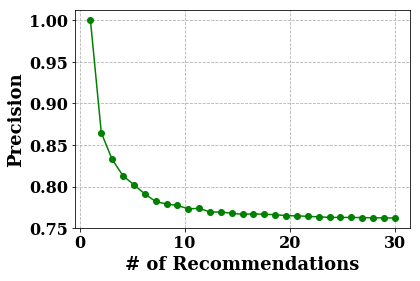

In [567]:
plt.figure(figsize=(6,4))
x=np.linspace(0,30,30)
plt.plot(x,precision_v,'-o',color='green')
plt.xlabel('# of Recommendations',fontsize=18)
plt.ylabel('Precision',fontsize=18)
plt.grid(True,ls='--')
plt.savefig('Plots/%s_%s_precision.png'%(week,day), bbox_inches='tight')
#plt.ylim(0,1)
#plt.

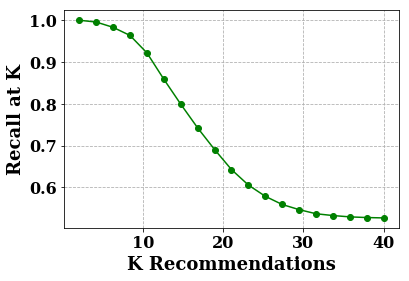

In [474]:
plt.figure(figsize=(6,4))
x=np.linspace(0,40,20)
plt.plot(x,recall_v,'-o',color='green')
plt.xlabel('K Recommendations',fontsize=18)
plt.ylabel('Recall at K',fontsize=18)
plt.grid(True,ls='--')
#plt.ylim(0,1)

In [426]:
t = .55 # user_ave_thresholds
print( '\n\nrecall @4 : %0.3f' % recall_at_k(blind_y_true_binarized, blind_y_pred_scaled_topk, user_ids,4, tol=t))
print( 'recall @8 : %0.3f' % recall_at_k(blind_y_true_binarized, blind_y_pred_scaled_topk, user_ids, 8, tol=t))
print( 'recall @16 : %0.3f' % recall_at_k(blind_y_true_binarized,blind_y_pred_scaled_topk, user_ids, 16, tol=t))
print( 'recall @32 : %0.3f' % recall_at_k(blind_y_true_binarized,blind_y_pred_scaled_topk, user_ids, 32, tol=t))

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)




recall @4 : 0.996
recall @8 : 0.964
recall @16 : 0.742
recall @32 : 0.533


In [241]:
random_pred = np.random.uniform(low=1, high=5, size=(len(blind_y_true,)))
random_pred_scaled = (random_pred - 1)/4

fpr_r, tpr_r, thresholds_r = roc_curve(blind_y_true_binarized, random_pred_scaled)
fpr_i, tpr_i, thresholds_i = roc_curve(blind_y_true_binarized, item_y_pred_scaled_topk)

In [243]:
# Recall, precision, and f1 are definied for binarized predictions  
print( 'Recall: %0.3f' % recall_score(blind_y_true_binarized, blind_y_pred_binarized_topk))
print( 'Precision: %0.3f' % precision_score(blind_y_true_binarized, blind_y_pred_binarized_topk))
print( 'F1 score: %0.3f' % f1_score(blind_y_true_binarized, blind_y_pred_binarized_topk))
print( 'ROC-AUC: %0.3f' % auc_score)

Recall: 0.673
Precision: 0.557
F1 score: 0.610
ROC-AUC: 0.649


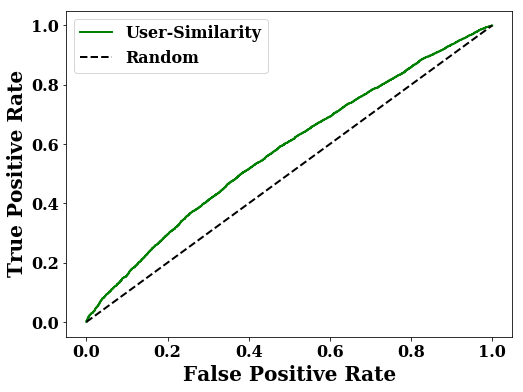

In [387]:
#Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_b, tpr_b, lw=2,color='green',label='User-Similarity') 
#plt.plot(fpr_r, tpr_r, lw=2,color='blue',label='Random') 
#plt.plot(fpr_i, tpr_i, lw=2,color='red',label='Item-Similarity') 

plt.plot([0, 1], [0, 1], 'k--',lw=2,label='Random')
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
#plt.grid(True)
plt.legend(fontsize=16)
plt.savefig('Plots/%s_%s_roc.png'%(week,day),bbox_to_inches='tight')

In [167]:
# Make recall over k
# r_s_v = []
# for i in range(1,100,5): 
#     r_s =recall_score(y_true_binarized[:i], y_pred_binarized_topk[:i])
#     #print (y_true_binarized[:i],y_pred_binarized_topk[:i])
#     r_s_v.append(r_s)
# r_s_x = np.linspace(1,100,20)
# plt.plot(r_s_x,r_s_v,'o-')

## Now try gradient descent

In [12]:
N_FEATURES = 30

X_mat = np.random.rand(N_BOOKS,N_FEATURES)
Theta_mat = np.random.rand(N_USERS,N_FEATURES)

X_Theta_rand = np.concatenate((X_mat.reshape([-1,1]),Theta_mat.reshape([-1,1])))

Y = ratings_mat.copy()
R = binary_mat.copy()

In [14]:
from scipy.optimize import fmin_cg

result = fmin_cg(cost, x0=X_Theta_rand,fprime=grad, \
                 args=(Y.T,R.T,1.5),\
                 maxiter=5,disp=True) 

Cost 29408560.917863566
Cost 29453207.06743269
Cost 29417554.315964222
Cost 29410394.111804977
Cost 29408935.503829215
Cost 29408637.497145787
Cost 29408576.575110443
Cost 29408564.119179748
Cost 29408561.572414707
Cost 29408561.051695254
Cost 29408560.945227243
Cost 29408560.923458423
Cost 29408560.919007488
Cost 29408560.918097455
Cost 29408560.91791137
Cost 29408560.91787332
Cost 29408560.917865556
Cost 29408560.91786396
Cost 29408560.917863645
Cost 29408560.91786358
Cost 29408560.917863566
Cost 29408560.917863574
Cost 29408560.917863574
Cost 29408560.917863566
Cost 29408560.917863566
Cost 29408560.917863574
Cost 29408560.917863566
Cost 29408560.917863566
Cost 29408560.917863566
Cost 29408560.917863566
Cost 29408560.917863566
Cost 29408560.917863566
Cost 29408560.917863566
Cost 29408560.917863566
Cost 29408560.917863566
Cost 29408560.917863566
Cost 29408560.917863566
Cost 29408560.917863574
Cost 29408560.917863566
Cost 29408560.917863566
Cost 29408560.917863566
Cost 29408560.9178635

In [15]:
rX, rTheta = reshape(result, N_BOOKS, N_USERS, N_FEATURES)
print (rX.shape,rTheta.shape)

(7337, 30) (537, 30)


In [16]:
prediction_matrix = rX.dot(rTheta.T)
predictions = prediction_matrix[:,-1]

In [18]:
pred_idxs_sorted = np.argsort(predictions)
pred_idxs_sorted = pred_idxs_sorted[::-1]

print(pred_idxs_sorted)

print( "Top recommendations for you:")
for i in range(6):
    
    ratings_book_idx = int(pred_idxs_sorted[i])
    df_temp = df_ratings_cut.query('book_idx == %d' % ratings_book_idx)
    book_id = df_temp.book_id.values[0]    
    
    new_book = df_books.query('book_id == %d'%book_id)    
    genre_i = new_book['genre'].values[0]

    print('Predicting book "%s", genre: "%s"' % \
    (new_book['title'].values[0],new_book['genre'].values[0]))


print('\n')
j=0
for i in range(len(ratings_mat[-1])):  

    if ratings_mat[-1][i] > 0:
        j += 1
        df_temp = df_ratings_cut.query('book_idx == %d' % i)
        book_id = df_temp.book_id.values[0]    
        new_book_2 = df_books.query('book_id == %d' % book_id)
        print ('Rated %d for "%s", genre: "%s"' % (ratings_mat[user_i][i],new_book_2['title'].values[0],new_book_2['genre'].values[0]))
    
    if j > 10:
        break

[4091 4175 4848 ... 5836 7220 3629]
Top recommendations for you:
Predicting book "Natchez Burning", genre: "mystery"
Predicting book "Debt of Bones (Sword of Truth, #0.5)", genre: "fantasy"
Predicting book "The Walk (The Walk, #1)", genre: "inspirational"
Predicting book "The Sellout", genre: "humor"
Predicting book "Jane Eyre", genre: "literature"
Predicting book "My Friend Flicka (Flicka, #1)", genre: "animals"


Rated 3 for "The Hunger Games (The Hunger Games, #1)", genre: "dystopian"
Rated 3 for "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)", genre: "fantasy"
Rated 5 for "Twilight (Twilight, #1)", genre: "fantasy"
Rated 4 for "To Kill a Mockingbird", genre: "classic"
Rated 2 for "The Great Gatsby", genre: "classic"
Rated 3 for "The Fault in Our Stars", genre: "romance"
Rated 3 for "The Hobbit", genre: "fantasy"
Rated 3 for "The Catcher in the Rye", genre: "classic"
Rated 3 for "Angels & Demons  (Robert Langdon, #1)", genre: "mystery"
Rated 3 for "Pride and Prejudice", g

In [221]:
# random_mat_mask = np.random.randint(100, size=(N_USERS, N_BOOKS))
# random_mat_mask[random_mat_mask > 1] = 0
# random_mat = random_mat_mask * orig_ratings_mat 
# random_mat *= binary_genre_mat

# random_nonzero_test = random_mat > 0

# random_y_true = random_mat[random_nonzero_test]
# random_y_pred_topk = user_prediction_topk[random_nonzero_test]
# random_y_pred_scaled_topk = (random_y_pred_topk - 1.) / 4

# random_user_ave_thresholds = user_ave_mat[random_nonzero_test]
 
# random_y_true = random_mat[random_nonzero_test]
# random_y_pred_topk = user_prediction_topk[random_nonzero_test]
# random_y_pred_scaled_topk = (random_y_pred_topk - 1.) / 4
# random_user_ave_thresholds = user_ave_mat[random_nonzero_test]
# #print (random_y_pred_scaled_topk )
# #print (random_y_true)

# # Binarize true values and predictions using user's average rating as a threshold
# random_y_true_binarized = binarize(random_y_true.copy(), random_user_ave_thresholds)
# random_y_pred_binarized_topk = binarize(random_y_pred_topk.copy(), random_user_ave_thresholds) 
#auc_score = roc_auc_score(random_y_true_binarized, random_y_pred_scaled_topk)
#fpr_r, tpr_r, _ = roc_curve(random_y_true_binarized, random_y_pred_scaled_topk)

In [211]:
weight = 1.5
threshold = 3. / weight

user_prediction_topk_genre = user_prediction_topk.copy()
user_genre_coords = np.argwhere( user_prediction_topk_genre > threshold)

for c in user_genre_coords:
    x, y = c[0], c[1]
    rating_i = user_prediction_topk_genre[x][y]

    # Get book id from the book_idx to link us to the df_books db genre for this rating entry
    ratings_book_id = df_ratings_cut.loc[df_ratings_cut['book_idx'] == int(y)]['book_id'].values[0]
    genre_xy = df_books.loc[df_books['book_id'] == ratings_book_id]['genre'].values[0]
    title_xy = df_books.loc[df_books['book_id'] == ratings_book_id]['title'].values[0]

    if genre_xy not in top_3_genres_names_per_user[x]:
        user_prediction_topk_genre[x][y] *= weight
        if x == N_USERS - 2 and user_prediction_topk_genre[x][y] > 4:
            print (y,genre_xy, title_xy, ratings_book_id, user_prediction_topk_genre[x][y])

In [39]:
# MAKE SURE INDEXING IS RIGHT HERE**g
# Sort first user's predictions from highest to lowest
user_i = -1; user_prediction_0 = user_prediction_topk_genre[user_i] 
pred_idxs_sorted = np.argsort(user_prediction_topk_genre[user_i] )
pred_idxs_sorted = pred_idxs_sorted[::-1]
print(pred_idxs_sorted)

print( "Top recommendations for you:")
for i in range(8):
    
    ratings_book_idx = int(pred_idxs_sorted[i])
    df_temp = df_ratings_cut.query('book_idx == %d' % ratings_book_idx)
    book_id = df_temp.book_id.values[0]    
    
    new_book = df_books.query('book_id == %d'%book_id)    
    genre_i = new_book['genre'].values[0]

    print('Predicting rating %0.2f for book "%s", genre: "%s"' % \
    (user_prediction_0[pred_idxs_sorted[i]],new_book['title'].values[0],new_book['genre'].values[0]))
      
j = 0
print ("\nOriginal ratings provided:")
print( top_3_genres_names_per_user[-2])
# for i in range(len(ratings_mat[user_i])):  
#     #print(i,user_i, sum(ratings_mat[user_i]))
#     if ratings_mat[user_i][i] > 0:
#         j += 1
#         df_temp = df_ratings_cut.query('book_idx == %d' % i)
#         book_id = df_temp.book_id.values[0]    
#         new_book_2 = df_books.query('book_id == %d' % book_id)
#         print ('Rated %d for "%s", genre: "%s"' % (ratings_mat[user_i][i],new_book_2['title'].values[0],new_book_2['genre'].values[0]))
    
#     if j > 5:
#         break

[ 112  917  703 ... 4366 4367 7336]
Top recommendations for you:
Predicting rating 2.90 for book "Catch-22", genre: "classic"
Predicting rating 2.85 for book "The Shipping News", genre: "contemporary"
Predicting rating 2.65 for book "The Cider House Rules", genre: "default"
Predicting rating 2.44 for book "Snow Falling on Cedars", genre: "mystery"
Predicting rating 2.38 for book "The House of the Spirits", genre: "fantasy"
Predicting rating 2.36 for book "A Room with a View", genre: "romance"
Predicting rating 2.28 for book "Fried Green Tomatoes at the Whistle Stop Cafe", genre: "lgbt"
Predicting rating 2.24 for book "The Pearl", genre: "classic"

Original ratings provided:
['fantasy', 'classic', 'romance']
